# Phys 512: Homework 5

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1. An adaptive Runge-Kutta integrator

In [119]:
# create function to define the velocity and acceleration in x and y of the planet
def derivs_orbit(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

In [120]:
# define Runge-Kutta integrator with adaptive timestep

def AdaptiveRungeKutta(x0, derivs):
    
    # Set initial condition
    x = np.copy(x0)
    t=0
    dt = 2 * np.pi / 1000
    # Store position/velocity data in a list
    x_store = [x] 
    
    while True:
       
        # Update x with current stepsize
        f = derivs(t, x)
        f1 = derivs(t + dt/2, x + f*dt/2)
        f2 = derivs(t + dt/2, x + f1*dt/2)
        f3 = derivs(t + dt, x + f2*dt)
        x_next1 = RungeKuttaStep(x, dt, t, derivs)
        

        # Update x twice with half-stepsize
        f = derivs(t, x)
        f1 = derivs(t + dt/4, x + f*dt/4)
        f2 = derivs(t + dt/4, x + f1*dt/4)
        f3 = derivs(t + dt/2, x + f2*dt/2)
        x_mid = x + dt/2*(f + 2*f1 + 2*f2 + f3)/6
        t_mid = t + dt/2

        f = derivs(t_mid, x_mid)
        f1 = derivs(t_mid + dt/4, x_mid + f*dt/4)
        f2 = derivs(t_mid + dt/4, x_mid + f1*dt/4)
        f3 = derivs(t_mid + dt/2, x_mid + f2*dt/2)
        x_next2 = x_mid + dt/2*(f + 2*f1 + 2*f2 + f3)/6
        
        # Define relative error between step sizes
        err = abs((x_next1[1] - x_next2[1])/x_next1[1])
        err = max(abs((x_next1 - x_next2)))
        
        # Check if error is less than desired tolerance
        if err <=1e-6:
            
            # Before accepting the step, check if this is the final timestep
            # if so, ajust dt so that the integration ends at t=2pi
            if t + dt >= 2*np.pi:

                dt = (2*np.pi - t)
                f = derivs(t, x)
                f1 = derivs(t+ dt/2, x + f*dt/2)
                f2 = derivs(t+dt/2, x + f1*dt/2)
                f3 = derivs(t+dt, x + f2*dt)
                x = x + dt*(f + 2*f1 + 2*f2 + f3)/6
                x_store.append(x)
                return np.array(x_store)
            
            # If this is not the final step, accept the result and update t
            x = x_next2
            x_store.append(x)
            t += dt
            # Increase dt by a factor of 2
            dt *= 2
            
            
        else:
            # if error is more than the desired tolerance, reject the step and decrease dt by a factor of 2
            dt /= 2

In [121]:
# define initial conditions 
e = 0.9
r1 = 1+e
v1 = np.sqrt((2/r1)-1)
x_start = np.array((r1,0,0,v1))

# Use adaptive Runge-Kutta integrator to solve for the trajectory of the planet during its elliptical orbit
x_adapt = AdaptiveRungeKutta(x_start, derivs_orbit)

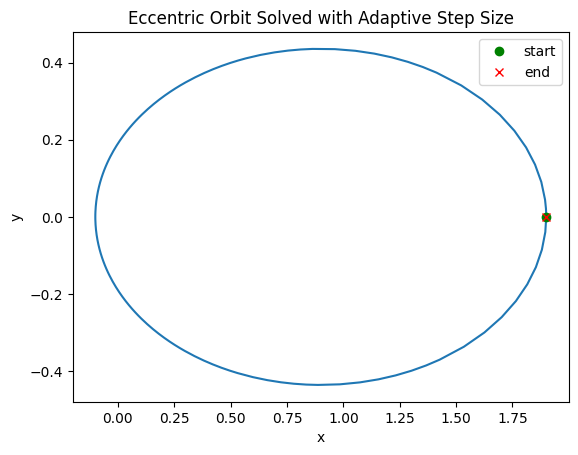

In [122]:
# Plot the planets orbit
plt.figure()
plt.title('Eccentric Orbit Solved with Adaptive Step Size')
plt.plot(x_adapt[:,0], x_adapt[:,1])
plt.plot(x_adapt[0,0], x_adapt[0,1], 'go', label='start')
plt.plot(x_adapt[-1,0], x_adapt[-1,1], 'rx', label='end')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [123]:
print("The adaptive Runge-Kutta integrator yeilds an error of", x_adapt[-1,1], "with", len(x_adapt), 'steps')

The adaptive Runge-Kutta integrator yeilds an error of 1.0192174858744685e-06 with 126 steps


In [124]:
# define Runge-Kutta integrator without adaptive timestep

def RungeKutta(nsteps, dt, x0, derivs):
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    for i in range(1,nsteps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)
        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x

In [125]:
# define initial conditions 
e = 0.9
r1 = 1+e
v1 = np.sqrt((2/r1)-1)
x_start = np.array((r1,0,0,v1))
nsteps = 4000
dt = 2 * np.pi / (nsteps-1)

# Use Runge-Kutta integrator to solve for the trajectory of the planet during its elliptical orbit
x = RungeKutta(nsteps, dt, x_start, derivs_orbit)

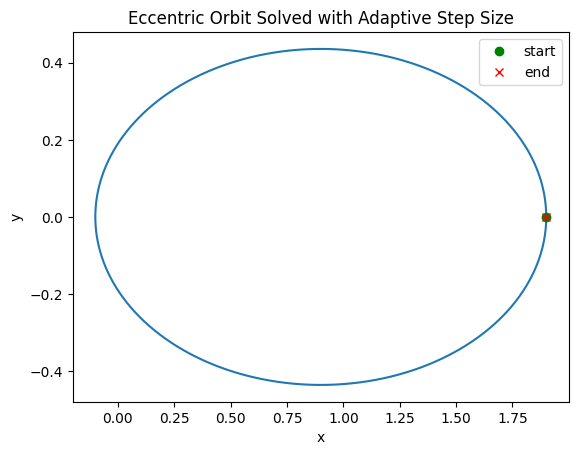

In [126]:
# Plot the planets orbit
plt.figure()
plt.title('Eccentric Orbit Solved with Adaptive Step Size')
plt.plot(x[:,0], x[:,1])
plt.plot(x[0,0], x[0,1], 'go', label='start')
plt.plot(x[-1,0], x[-1,1], 'rx', label='end')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [127]:
print("The Runge-Kutta integrator with constant timestep yeilds an error of", x[-1,1], "with", nsteps, 'steps')

The Runge-Kutta integrator with constant timestep yeilds an error of 1.0283163601952877e-06 with 4000 steps


The Runge-Kutta method with an adaptive timestep can yeild an error on the order of $10^{-6}$ in 126 steps. The Runge-Kutta method with an constant timestep obtains a similar error after 4000. The adaptive timestep therefore makes the integrator approximately 400 times more efficient.

## 2. Method of lines

In [128]:
# Define grid size
N = 100
dx = 1/N

# Create a matrix to define the sytem of coupled ODEs
C = np.zeros(shape=(N, N))
for i in range(1, N - 1):
        C[i][i - 1] = -1
        C[i][i] = 2
        C[i][i + 1] = -1
C /= dx**2

In [129]:
# Define a timestep and step count
dt = 2e-3
nsteps = 100
t = dt * np.arange(nsteps)

In [130]:
# Initalize a grid to record the evolution of the bars temperature
# Set first row to initial conditions
x = np.ones((nsteps, N))
x[:,-1]  = 0

bar = np.linspace(0, 1, N)

In [131]:
# perform the backwards Euler method to update the temperature array at each timestep
A = np.linalg.inv(np.identity(N) + dt*C)
for i in range(1,nsteps):
    x[i] = A@x[i-1]  

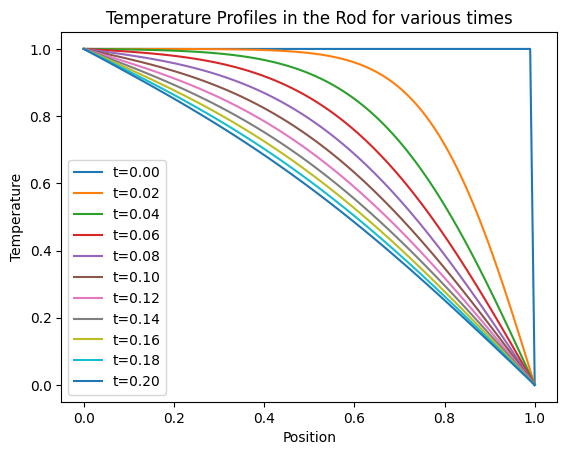

In [132]:
# plot the temperature profiles for different times
indices = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89 , 99]

fig = plt.figure()
plt.title('Temperature Profiles in the Rod for various times')
for i in indices:       
    plt.plot(bar, x[i], label=f't=%.2f' % t[i])
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Initially, the entire rod is at 1 except for the final index which is at 0. As we allow heat to transfer within the rod, the distribution begins to smooth out. The left side of the curve remains mostly flat while the right side of the curve drops of quickly. This is expected since the left hand side of the rod interacts with with the temperature change earlier. After sufficient time has passed, the distrabution spreads out and approaches a linear funtion. This makes sense. Since one of end is held at 1, and the other end is held at zero, the expected heat distrabution in the rod at thermal equilibrium is a linear deacrease from 1 to 0. A more complete picture of the time evolution of the rod is given in the color map below.

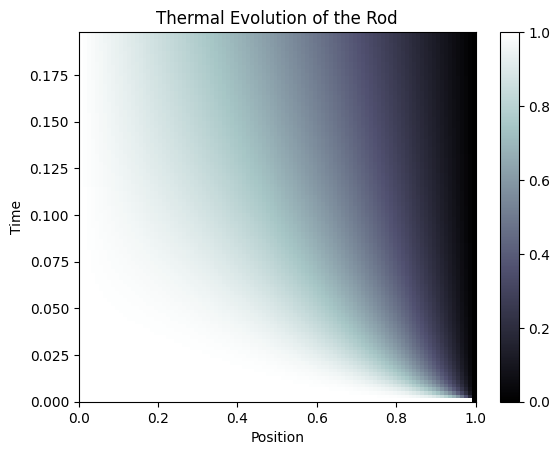

In [133]:
# Plot the time evolution of the rod on a colour map 
extent = (0, 1, t[0], t[-1])
plt.title('Thermal Evolution of the Rod')
plt.imshow(x, aspect='auto', origin='lower', extent=extent, cmap='bone') 
plt.xlabel('Position')
plt.ylabel('Time')
plt.colorbar() 